In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import scanpy.external as sce
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
import math
import warnings
import scvelo as scv
import cellrank as cr
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 0  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.set_figure_params(scanpy=True, dpi=100, dpi_save=500, frameon=False, vector_friendly=True, fontsize=14, figsize=None, color_map=None, format='pdf', facecolor=None, transparent=True)

In [2]:
import helper_functions_dew as dew
import pickle

### Clusters

In [27]:
somitoid = sc.read('data/somitoid_post.h5ad')
somitoid = somitoid[~somitoid.obs['leiden'].isin(['iPSC']),:]

In [28]:
segmentoidClassifier = pickle.load(open('data/segmentoidClassifier.pickle','rb'))
somitoid = dew.predict_classes(somitoid, segmentoidClassifier)

Trying to set attribute `.X` of view, copying.


In [29]:
def plot_confusion_matrix_leiden(labels_A, labels_B,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues,
                          overlay_values=False,
                          vmin=None,
                          vmax=None,
                          return_data=False):
    '''
    Plots a confusion matrix comparing two sets labels. 

    '''

    from sklearn.metrics import confusion_matrix
    from sklearn.utils.multiclass import unique_labels
    
    cm = confusion_matrix(labels_A, labels_B,labels=['NMP', 'PSM Post', 'PSM Ant', 'Somite','Neural'])
    non_empty_rows = cm.sum(axis=0)!=0
    non_empty_cols = cm.sum(axis=1)!=0
    cm = cm[:,non_empty_rows]
    cm = cm[non_empty_cols,:]
    cm = cm.T
    
    classes = np.unique(labels_A.append(labels_B))
    xaxis_labels = classes[non_empty_cols]
    yaxis_labels = classes[non_empty_rows]

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    if normalize:
        colorbar_label = 'Fraction Overlap'
        if not title:
            title = 'Normalized confusion matrix'
    else:
        colorbar_label = '# Overlaps'
        if not title:
        	title = 'Confusion matrix, without normalization'  
  
    if hasattr(labels_A, 'name'):
        labels_A_name = labels_A.name #.capitalize()   	
    else:
        labels_A_name = 'Label A'
    if hasattr(labels_B, 'name'):
        labels_B_name = labels_B.name #.capitalize()    	
    else:
        labels_B_name = 'Label B'

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap, vmin=vmin, vmax=vmax)
    
    xaxis_labels=['NMP', 'PSM Post', 'PSM Ant', 'Somite','Neural']
    yaxis_labels=['NMP', 'PSM Post', 'PSM Ant', 'Somite']
    
    ax.grid(False)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=xaxis_labels, yticklabels=yaxis_labels,
           title=title,
           ylabel=labels_B_name,
           xlabel=labels_A_name)

    plt.setp(ax.get_xticklabels(), rotation=90, ha="right", va='top',
             rotation_mode='anchor',fontsize=10)
    plt.setp(ax.get_yticklabels(), fontsize=10)

    cb=ax.figure.colorbar(im, ax=ax, shrink=0.5)
    cb.ax.tick_params(labelsize=10) 
    cb.ax.set_ylabel(colorbar_label, rotation=90)
    
    if overlay_values:
        fmt = '.1f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black",
                        size=8)
    ax.set_aspect('equal') 
    
    if return_data:
        return fig, ax, cm, xaxis_labels, yaxis_labels                        
    else:
        return fig, ax                   


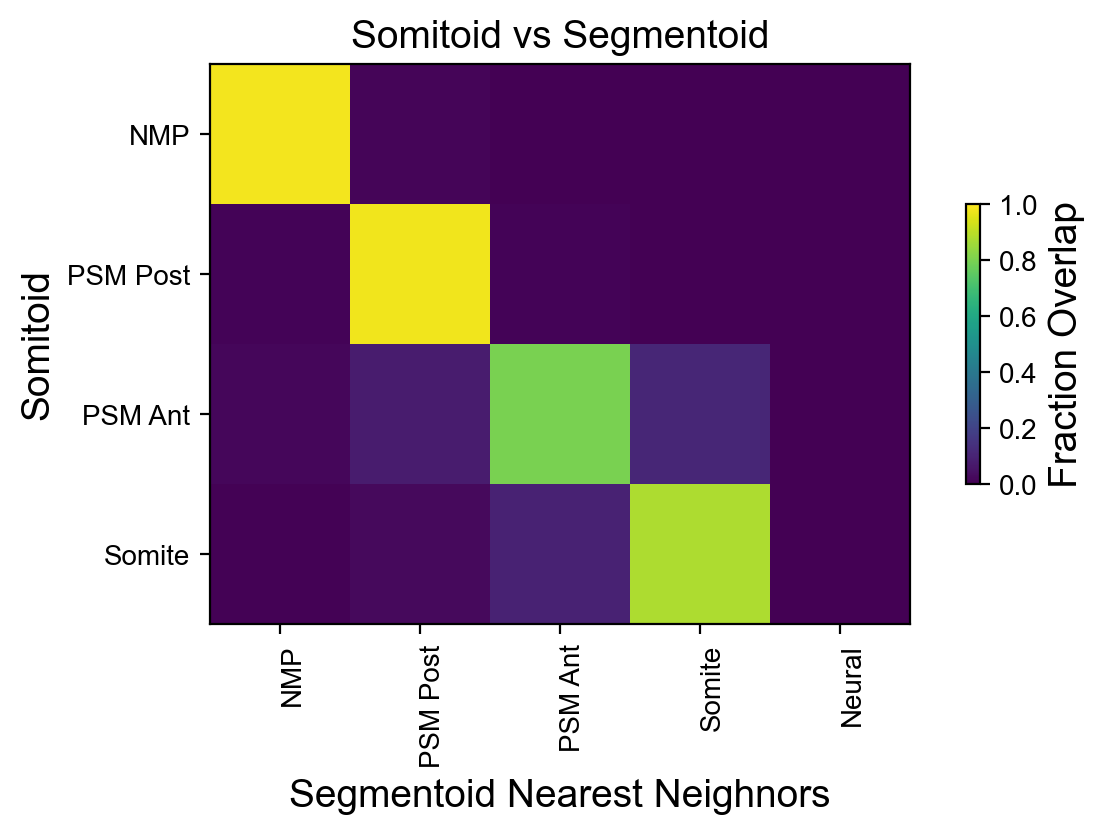

In [30]:
alg = ['NearestNeighbors']

for al in alg:
    plot_confusion_matrix_leiden(somitoid.obs['pr_'+al],somitoid.obs['leiden'], title=' ', 
                              normalize=True, cmap='viridis', vmin=0, vmax=1)
    plt.title("Somitoid vs Segmentoid")
    plt.ylabel("Somitoid")
    plt.xlabel("Segmentoid Nearest Neighnors")
    plt.subplots_adjust(bottom=0, left=0, right=1.4, top=0.7)
    plt.savefig('figures/classifier.pdf', dpi=600, bbox_inches='tight')

### Timepoint

In [19]:
somitoid = sc.read('data/somitoid_post.h5ad')
somitoid = somitoid[~somitoid.obs['timepoint'].isin(['iPSC']),:]

In [21]:
segmentoidClassifier = pickle.load(open('data/segmentoidClassifiertimepoint.pickle','rb'))
somitoid = dew.predict_classes(somitoid, segmentoidClassifier)

Trying to set attribute `.X` of view, copying.


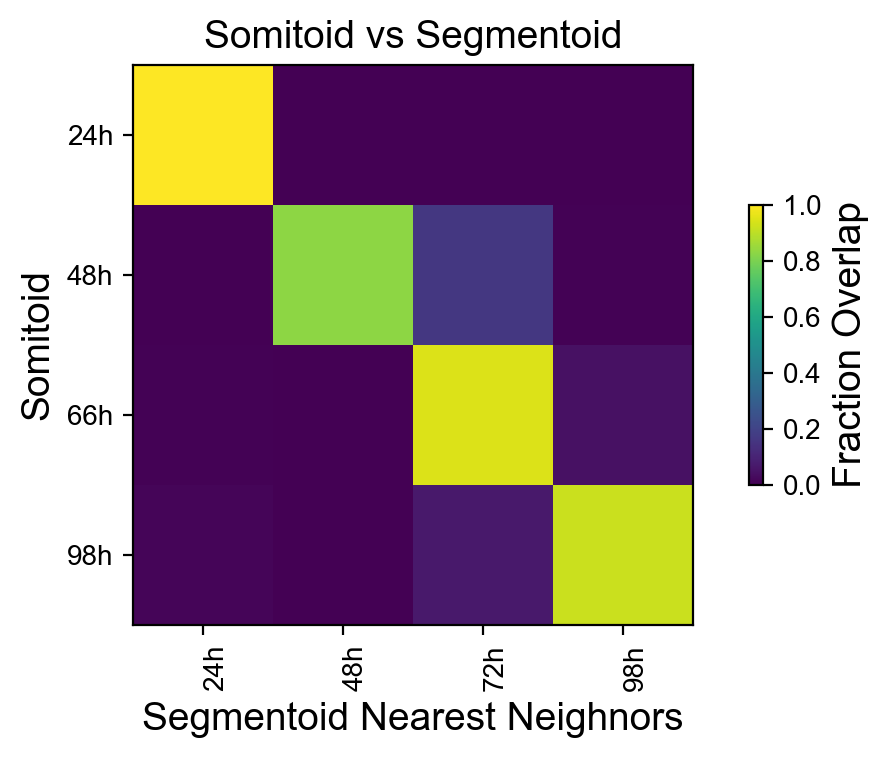

In [22]:
alg = ['NearestNeighbors']

for al in alg:
    dew.plot_confusion_matrix(somitoid.obs['pr_'+al],somitoid.obs['timepoint'], title=' ', 
                              normalize=True, cmap='viridis', vmin=0, vmax=1,return_data=True)
    plt.title("Somitoid vs Segmentoid")
    plt.ylabel("Somitoid")
    plt.xlabel("Segmentoid Nearest Neighnors")
    plt.subplots_adjust(bottom=0, left=0, right=1.4, top=0.7)
    plt.savefig('figures/classifiertimepoint.pdf', dpi=600, bbox_inches='tight')